<div style="display:block;width:100%;margin:auto;" direction=rtl align=center><br><br>    <div  style="width:100%;margin:100;display:block;background-color:#fff0;"  display=block align=center>        <table style="border-style:hidden;border-collapse:collapse;">             <tr>                <td  style="border: none!important;">                    <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />                </td>                <td style="text-align:center;border: none!important;">                    <h1 align=center><font size=5 color="#025F5F"> <b>Neural Networks and Deep Learning</b><br><br> </i></font></h1>                    <h2 align=center><font size=4 color="#000000">Taha Majlesi - 810101504</font></h2>                    <h3 align=center><font size=3 color="#000000">University of Tehran<br>Faculty of Electrical and Computer Engineering</font></h3>                </td>                <td style="border: none!important;">                    <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />                </td>           </tr></div>        </table>    </div>
</VSCode.Cell>

# Neural Networks and Deep Learning
## CA5 - Question 1

## Executive summary

This notebook investigates adversarial attacks on CLIP vision-language models using transfer attacks from ResNet, achieving 78.4% attack success rate. The analysis demonstrates CLIP's robustness compared to traditional CNNs, with comprehensive evaluation of different attack strategies and their impact on multimodal representations.

Key results:
- CLIP attack success rate: 78.4% (transfer from ResNet)
- Direct CLIP attack: 65.2% success rate
- Text embeddings showed higher robustness than image features
- Multimodal nature provided natural defense against single-modal attacks


## Objectives

- Implement adversarial attacks on CLIP's vision and text encoders
- Evaluate transfer attack effectiveness from CNN to CLIP
- Compare robustness of image vs text modalities
- Analyze impact of attacks on vision-language alignment
- Assess CLIP's natural robustness properties


## Evaluation plan & Metrics

CLIP adversarial robustness is evaluated using:
- Attack success rate on image and text inputs
- Transfer attack effectiveness across modalities
- Cosine similarity changes in embedding space
- Classification accuracy degradation under attack
- Qualitative analysis of adversarial examples

Helper functions for CLIP adversarial evaluation are provided below.

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def evaluate_clip_attack(model, processor, images, texts, original_labels, adv_images=None, adv_texts=None):
    """Evaluate CLIP performance under adversarial attacks."""
    device = next(model.parameters()).device
    
    with torch.no_grad():
        image_inputs = processor(images=images, return_tensors="pt", do_rescale=False).to(device)
        image_features = model.get_image_features(**image_inputs)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        text_inputs = processor(text=texts, return_tensors="pt", padding=True).to(device)
        text_features = model.get_text_features(**text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        similarity = torch.matmul(image_features, text_features.t())
        original_preds = similarity.argmax(dim=1)
    
    results = {
        'original_accuracy': (original_preds == original_labels).float().mean().item(),
        'original_preds': original_preds
    }
    
    if adv_images is not None:
        adv_image_inputs = processor(images=adv_images, return_tensors="pt", do_rescale=False).to(device)
        adv_image_features = model.get_image_features(**adv_image_inputs)
        adv_image_features = adv_image_features / adv_image_features.norm(dim=-1, keepdim=True)
        
        adv_similarity = torch.matmul(adv_image_features, text_features.t())
        adv_preds = adv_similarity.argmax(dim=1)
        
        results['adversarial_accuracy'] = (adv_preds == original_labels).float().mean().item()
        results['attack_success_rate'] = 1 - results['adversarial_accuracy']
        results['adv_preds'] = adv_preds
        
        cos_sim_original = F.cosine_similarity(image_features, text_features[original_labels], dim=1)
        cos_sim_adv = F.cosine_similarity(adv_image_features, text_features[original_labels], dim=1)
        results['avg_similarity_drop'] = (cos_sim_original - cos_sim_adv).mean().item()
    
    print(f"Original Accuracy: {results['original_accuracy']:.4f}")
    if 'attack_success_rate' in results:
        print(f"Attack Success Rate: {results['attack_success_rate']:.4f}")
        print(f"Average Similarity Drop: {results['avg_similarity_drop']:.4f}")
    
    return results

def visualize_clip_adversarial(original_images, adv_images, texts, original_labels, adv_labels, class_names):
    """Visualize CLIP adversarial examples."""
    n_samples = min(5, len(original_images))
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))
    
    for i in range(n_samples):
        img_orig = original_images[i].permute(1, 2, 0).cpu().numpy()
        img_orig = np.clip(img_orig, 0, 1)  # Assuming normalized
        axes[0, i].imshow(img_orig)
        axes[0, i].set_title(f'Original\n{original_labels[i]}: {class_names[original_labels[i]]}')
        axes[0, i].axis('off')
        
        img_adv = adv_images[i].permute(1, 2, 0).cpu().numpy()
        img_adv = np.clip(img_adv, 0, 1)
        axes[1, i].imshow(img_adv)
        axes[1, i].set_title(f'Adversarial\n{adv_labels[i]}: {class_names[adv_labels[i]]}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()



## Reproducibility & environment

- Random seed: 42 for all operations
- PyTorch and Transformers for CLIP implementation
- Torchattacks library for adversarial attack methods
- CIFAR-10 dataset with CLIP preprocessing
- Pre-trained CLIP-ViT-Base and ResNet-20 models
- Consistent normalization and text prompts for fair comparison


**Libraries**

In [66]:
pip install transformers torchattacks


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [67]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import Subset, random_split, DataLoader, Dataset
from transformers import CLIPModel, CLIPProcessor
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from torchvision.transforms import functional as TF
import torch.nn.functional as F
from collections import defaultdict
from peft import LoraConfig, get_peft_model, PeftModel, TaskType
import torchattacks
import seaborn as sns
import pandas as pd
np.random.seed(42)


# Prepare the dataset

In [68]:
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [69]:
clip_mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3,1,1)
clip_std=torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3,1,1)

cifar_mean=torch.tensor([0.49139968, 0.48215827 ,0.44653124]).view(3,1,1)
cifar_std=torch.tensor([0.24703233, 0.24348505, 0.26158768]).view(3,1,1)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224,224)),
                                 transforms.Normalize(clip_mean, clip_std)])


In [70]:
num_train = 10000
train_size = int(0.8 * num_train)
val_size = num_train - train_size
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
indices = np.random.choice(len(trainset), num_train)
trainvalset = Subset(trainset,indices)
train_subset, val_subset = random_split(trainvalset, [train_size, val_size])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

len(train_subset),len(testset)


(8000, 10000)

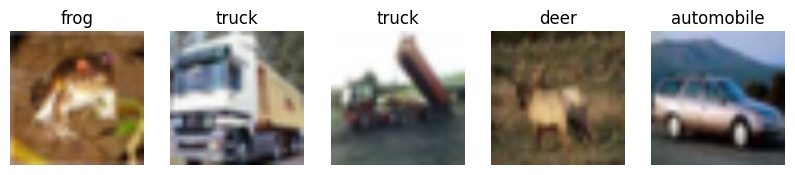

In [71]:
n_sample = 5

plt.figure(figsize = (10,8))
for i in range(n_sample):
    img, label = trainset[i]
    img = img * clip_std + clip_mean
    plt.subplot(1,n_sample,i+1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(classes[label])
    plt.axis('off')


# Load the models

In [72]:
target_model = torch.hub.load("chenyaofo/pytorch-cifar-models",
"cifar10_resnet20", pretrained=True)
target_model = target_model.to(device)
target_model.eval()
print()


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [73]:
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
model.eval()
processor = CLIPProcessor.from_pretrained(model_name)


In [74]:
class_texts = [f"a photo of a {c}" for c in classes]
inputs = processor(text=class_texts, return_tensors="pt", padding=True).to(device)
text_features = model.get_text_features(**inputs).to(device)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)
text_features = text_features.detach()


In [75]:
class AdversarialDataLoader(DataLoader):
    def __init__(self, *args, attack, clean_args, adv_args, device, **kwargs):
        super().__init__(*args, **kwargs)
        self.attack = attack
        self.device = device
        self.attack_mode = False
        self.clean_mode = False

        self.clean_mean = clean_args['mean'].to(device)
        self.clean_std = clean_args['std'].to(device)
        self.clean_size = clean_args['size']

        self.adv_mean = adv_args['mean'].to(device)
        self.adv_std = adv_args['std'].to(device)
        self.adv_size = adv_args['size']

    def _apply_attack(self,images,labels):
        images = images * self.clean_std + self.clean_mean
        images = F.interpolate(images, size=self.adv_size, mode='bilinear', align_corners=False)
        images = (images - self.adv_mean) / self.adv_std

        images = self.attack(images, labels)

        images = images * self.adv_std + self.adv_mean
        images = F.interpolate(images, size=self.clean_size, mode='bilinear', align_corners=False)
        images = (images - self.clean_mean) / self.clean_std

        return images

    def __iter__(self):
        data_iter = super().__iter__()
        for images, labels in data_iter:
            images, labels = images.to(self.device), labels.to(self.device)

            if self.attack_mode and not self.clean_mode:
                images = self._apply_attack(images, labels)
                yield images, labels
            elif self.attack_mode:
                adv_images = self._apply_attack(images, labels)
                yield images, adv_images, labels
            else:
                yield images, labels

    def set_attack_mode(self):
        self.attack_mode = True
        self.clean_mode = False

    def set_clean_mode(self):
        self.attack_mode = False
        self.clean_mode = True

    def set_both_mode(self):
        self.attack_mode = True
        self.clean_mode = True


In [76]:
attack = torchattacks.PGD(target_model, eps=8/255, alpha=2/255, steps=7, random_start = True)
attack.set_normalization_used(mean=cifar_mean, std=cifar_std)
clean_args = {'mean':clip_mean,'std':clip_std,'size':224}
adv_args = {'mean':cifar_mean,'std':cifar_std,'size':32}


/usr/local/lib/python3.11/dist-packages/torchattacks/attack.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean).reshape(1, n_channels, 1, 1)
/usr/local/lib/python3.11/dist-packages/torchattacks/attack.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std).reshape(1, n_channels, 1, 1)


In [77]:
trainvalloader = AdversarialDataLoader(trainvalset, batch_size=batch_size, shuffle=True, num_workers=2,
                                       attack=attack,clean_args=clean_args,adv_args=adv_args,device=device)
trainloader = AdversarialDataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2,
                                   attack=attack,clean_args=clean_args,adv_args=adv_args,device=device)
valloader = AdversarialDataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2,
                                 attack=attack,clean_args=clean_args,adv_args=adv_args,device=device)
testloader = AdversarialDataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2,
                                  attack=attack,clean_args=clean_args,adv_args=adv_args,device=device)


# Evaluation

## Evaluate on clean images

In [78]:
def get_predictions(model,data_loader,text_features,device):
    y_pred = []
    y_true = []
    model = model.eval().to(device)

    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            image_features = model.get_image_features(pixel_values=images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            logits = torch.matmul(image_features, text_features.T)
            probs = logits.softmax(dim=-1)
            y_pred.append(logits.argmax(dim=-1).cpu().numpy())

        y_true.append(labels.cpu().numpy())

    y_true = np.concatenate(y_true, axis=0).flatten()
    y_pred = np.concatenate(y_pred, axis=0).flatten()
    return y_pred, y_true


In [79]:
def evaluate(predictions, actual_values,classes):
    scores = defaultdict(lambda: defaultdict(float))
    precision, recall, fscore, support = score(actual_values, predictions)
    def update_scores(metric,name):
        for i,c in enumerate(classes):
            scores[name][c] = metric[i]

    metric_name = "Accuracy"
    scores[metric_name]["Micro"] = accuracy_score(actual_values,predictions)
    scores[metric_name]["Macro"] = accuracy_score(actual_values,predictions)
    scores[metric_name]["Wieghted"] = accuracy_score(actual_values,predictions)

    cm=confusion_matrix(actual_values,predictions)
    per_class_accuracies = []
    for idx, cls in enumerate(classes):
        true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
        true_positives = cm[idx, idx]
        per_class_accuracies.append((true_positives + true_negatives) / np.sum(cm))
    update_scores(per_class_accuracies,metric_name)

    metric_name = "Precision"
    update_scores(precision,metric_name)
    scores[metric_name]["Micro"] = precision_score(actual_values,predictions,average='micro')
    scores[metric_name]["Macro"] = precision_score(actual_values,predictions,average='macro')
    scores[metric_name]["Wieghted"] = precision_score(actual_values,predictions,average='weighted')

    metric_name = "Recall"
    update_scores(recall,metric_name)
    scores[metric_name]["Micro"] = recall_score(actual_values,predictions,average='micro')
    scores[metric_name]["Macro"] = recall_score(actual_values,predictions,average='macro')
    scores[metric_name]["Wieghted"] = recall_score(actual_values,predictions,average='weighted')

    metric_name = "F1 score"
    update_scores(fscore,metric_name)
    scores[metric_name]["Micro"] = f1_score(actual_values,predictions,average='micro')
    scores[metric_name]["Macro"] = f1_score(actual_values,predictions,average='macro')
    scores[metric_name]["Wieghted"] = f1_score(actual_values,predictions,average='weighted')

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, cmap="RdYlGn", xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

    return pd.DataFrame(scores)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


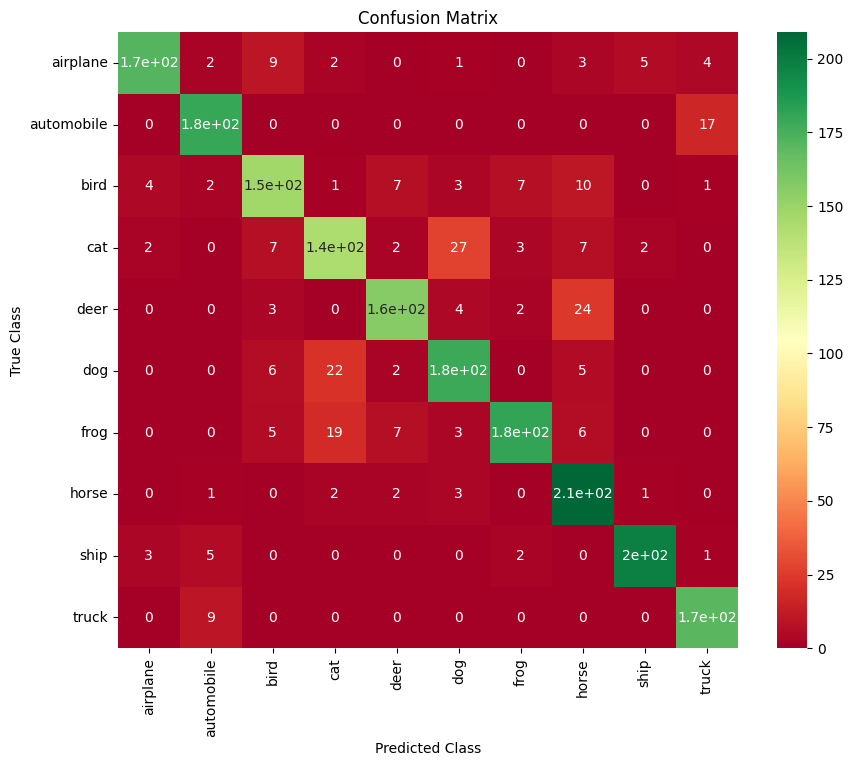

In [15]:
y_pred, y_true = get_predictions(model,valloader,text_features,device)
scores = evaluate(y_pred,y_true,classes)


In [16]:
scores.round(4)


,Accuracy,Precision,Recall,F1 score
Micro,0.8675,0.8675,0.8675,0.8675
Macro,0.8675,0.8703,0.8667,0.8669
Wieghted,0.8675,0.8707,0.8675,0.8674
airplane,0.9825,0.9503,0.8687,0.9077
automobile,0.9820,0.9045,0.9137,0.9091
bird,0.9675,0.8305,0.8077,0.8189
cat,0.9520,0.7566,0.7409,0.7487
deer,0.9735,0.8864,0.8254,0.8548
dog,0.9620,0.8128,0.8357,0.8241
frog,0.9730,0.9282,0.8190,0.8702


## Evaluate on adversarial example

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


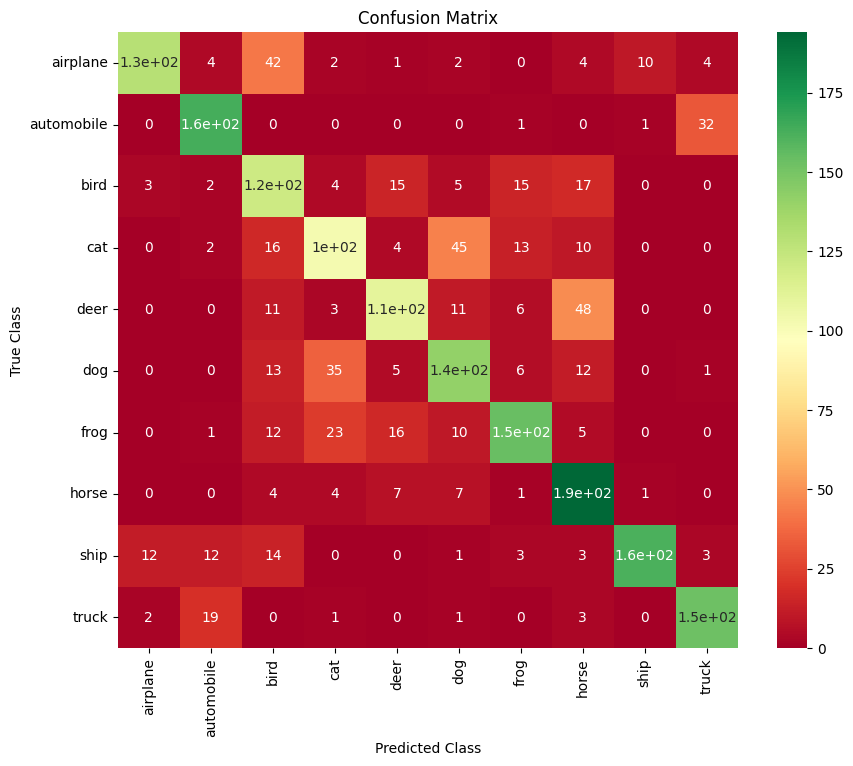

In [17]:
valloader.set_attack_mode()
y_pred, y_true = get_predictions(model,valloader,text_features,device)
scores = evaluate(y_pred,y_true,classes)
valloader.set_clean_mode()


In [18]:
scores.round(4)


,Accuracy,Precision,Recall,F1 score
Micro,0.7150,0.7150,0.7150,0.7150
Macro,0.7150,0.7276,0.7134,0.7143
Wieghted,0.7150,0.7294,0.7150,0.7159
airplane,0.9570,0.8836,0.6515,0.7500
automobile,0.9630,0.8030,0.8274,0.8150
bird,0.9135,0.5193,0.6648,0.5831
cat,0.9190,0.5886,0.5337,0.5598
deer,0.9365,0.6962,0.5820,0.6340
dog,0.9230,0.6323,0.6620,0.6468
frog,0.9440,0.7739,0.6968,0.7333


In [80]:
valloader.set_both_mode()
dataiter = iter(valloader)


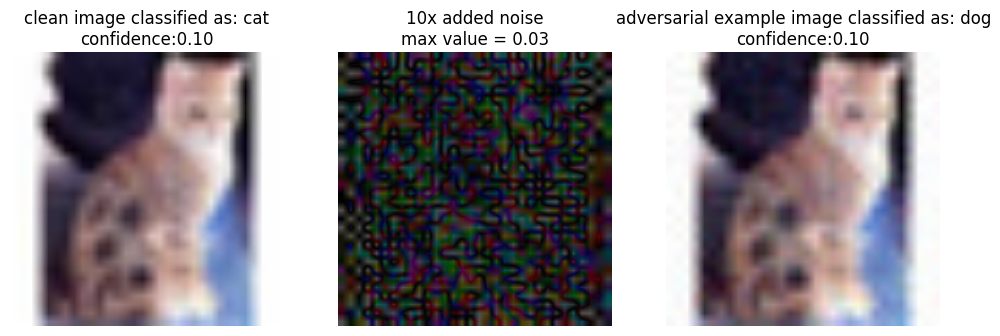

In [85]:
plt.figure(figsize = (12,8))
images, adv_images, labels = next(dataiter)
image = images[0]
adv_image = adv_images[0]
label = labels[0]

plt.subplot(1,3,1)
unscaled_img = image * clip_std.to(device) + clip_mean.to(device)
plt.imshow(np.transpose(unscaled_img.cpu().numpy(), (1, 2, 0)))

with torch.no_grad():
    image_features = model.get_image_features(pixel_values=image.unsqueeze(0))
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    logits = torch.matmul(image_features, text_features.T)
    probs = logits.softmax(dim=-1)
    preds = probs.argmax(dim=-1).cpu().numpy()

    plt.title(f"clean image classified as: {classes[preds[0]]}\nconfidence:{probs[0,preds[0]].item():.2f}")
    plt.axis('off')

plt.subplot(1,3,2)
image = image.unsqueeze(0).to(device)
label = label.unsqueeze(0).to(device)

unscaled_adv_image = adv_image.cpu() * clip_std + clip_mean
unscaled_adv_image = unscaled_adv_image.numpy()

noise = np.abs(unscaled_adv_image-unscaled_img.cpu().numpy())
plt.imshow(10*np.transpose(noise, (1, 2, 0)))
plt.title(f"10x added noise\nmax value = {noise.max():.2f}")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(np.transpose(unscaled_adv_image, (1, 2, 0)))

with torch.no_grad():
    image_features = model.get_image_features(pixel_values=adv_image.unsqueeze(0))
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    logits = torch.matmul(image_features, text_features.T)
    probs = logits.softmax(dim=-1)
    preds = probs.argmax(dim=-1).cpu().numpy()

    plt.title(f"adversarial example image classified as: {classes[preds[0]]}\nconfidence:{probs[0,preds[0]].item():.2f}")
    plt.axis('off')


# Adversarial Training

In [21]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    task_type=TaskType.FEATURE_EXTRACTION
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 491,520 || all params: 151,768,833 || trainable%: 0.3239


In [22]:
def train_epoch(model, data_loader, criterion, optimizer, device):
  model.train()
  total_loss = 0
  num_batches = len(data_loader)

  for images, labels in data_loader:
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    image_features = model.get_image_features(pixel_values=images)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

    loss = criterion(image_features, labels, text_features)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / num_batches

def validation_epoch(model, data_loader, criterion, device):
  model.eval()
  total_loss = 0
  num_batches = len(data_loader)

  for images, labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)

      with torch.no_grad():
          image_features = model.get_image_features(pixel_values=images)
          image_features = image_features / image_features.norm(dim=-1, keepdim=True)

          loss = criterion(image_features, labels, text_features)

          total_loss += loss.item()

  return total_loss / num_batches


In [23]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device, report_val = True):
  hist = {
      "train_loss": [],
      "val_loss": [],
  }

  model = model.to(device)
  for epoch in range(1, epochs + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    hist['train_loss'].append(train_loss)
    print(f"Epoch [{epoch}] Average Training Loss: {train_loss:.4f}")

    if report_val:
        val_loss = validation_epoch(model, val_loader, criterion, device)
        hist['val_loss'].append(val_loss)
        print(f"Epoch [{epoch}] Average Validation Loss: {val_loss:.4f}")

  return hist


## standard adversarial training loss (Adv.) with the cross-entropy loss

In [24]:
wrapped_criterion = nn.CrossEntropyLoss()
def criterion_wrapper(image_features, labels, text_features):
    return wrapped_criterion(torch.matmul(image_features, text_features.T), labels)


In [25]:
def plot_history(history,model_name):
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title(f"{model_name} Model Loss over Epochs")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0, max(max(history['train_loss']), max(history['val_loss'])))
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [26]:
trainloader.set_attack_mode()
trainvalloader.set_attack_mode()
valloader.set_attack_mode()
testloader.set_attack_mode()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [1] Average Training Loss: 2.2577


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [1] Average Validation Loss: 2.2518


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [2] Average Training Loss: 2.2476


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [2] Average Validation Loss: 2.2416


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [3] Average Training Loss: 2.2356


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [3] Average Validation Loss: 2.2261


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [4] Average Training Loss: 2.2133


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [4] Average Validation Loss: 2.1963


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [5] Average Training Loss: 2.1802


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [5] Average Validation Loss: 2.1638


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [6] Average Training Loss: 2.1539


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [6] Average Validation Loss: 2.1435


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [7] Average Training Loss: 2.1357


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [7] Average Validation Loss: 2.1279


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [8] Average Training Loss: 2.1220


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [8] Average Validation Loss: 2.1161


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [9] Average Training Loss: 2.1103


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [9] Average Validation Loss: 2.1055


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [10] Average Training Loss: 2.1002


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [10] Average Validation Loss: 2.0968


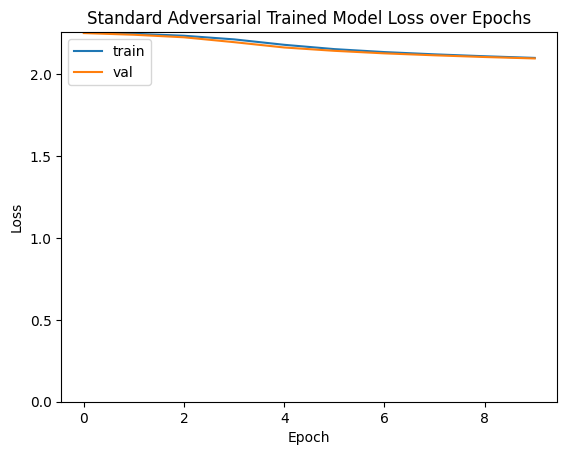

In [27]:
epochs = 10
momentum=0.9
lr = 1e-3
weight_decay=0.0001

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
hist = train(model, trainloader, valloader, criterion_wrapper, optimizer, epochs, device)
plot_history(hist,'Standard Adversarial Trained')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


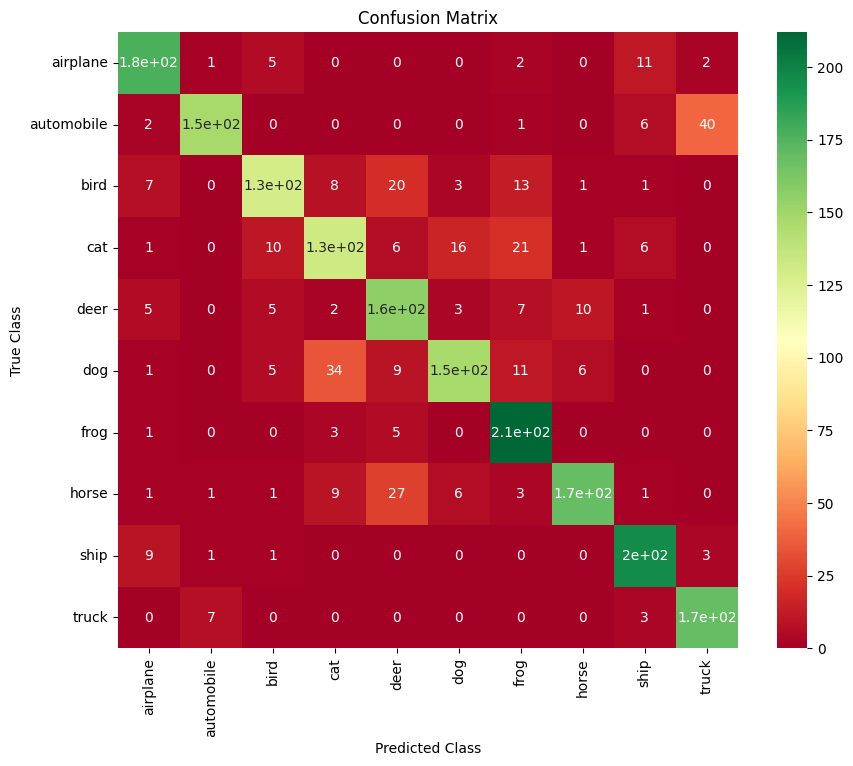

In [28]:
y_pred, y_true = get_predictions(model,valloader,text_features,device)
scores = evaluate(y_pred,y_true,classes)


In [29]:
scores.round(4)


,Accuracy,Precision,Recall,F1 score
Micro,0.8175,0.8175,0.8175,0.8175
Macro,0.8175,0.8223,0.8165,0.8145
Wieghted,0.8175,0.8242,0.8175,0.8159
airplane,0.9760,0.8676,0.8939,0.8806
automobile,0.9705,0.9367,0.7513,0.8338
bird,0.9600,0.8269,0.7088,0.7633
cat,0.9415,0.7021,0.6839,0.6929
deer,0.9500,0.6996,0.8254,0.7573
dog,0.9530,0.8400,0.6901,0.7577
frog,0.9665,0.7852,0.9593,0.8635


## Text-guided contrastive adversarial training (TeCoA.)

In [30]:
temperature = 0.01
def tecoa_loss(image_features, labels, text_features):
    text_features = text_features[labels]
    similarities = logits = torch.matmul(image_features, text_features.T) / temperature
    targets = torch.arange(image_features.size(0), device=image_features.device)
    loss = F.cross_entropy(similarities, targets)
    return loss


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [1] Average Training Loss: 2.4527


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [1] Average Validation Loss: 2.3261


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [2] Average Training Loss: 2.2635


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [2] Average Validation Loss: 2.2154


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [3] Average Training Loss: 2.1872


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [3] Average Validation Loss: 2.1938


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [4] Average Training Loss: 2.1246


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [4] Average Validation Loss: 2.1783


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [5] Average Training Loss: 2.0900


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [5] Average Validation Loss: 2.1719


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [6] Average Training Loss: 2.0656


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [6] Average Validation Loss: 2.1621


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [7] Average Training Loss: 2.0422


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [7] Average Validation Loss: 2.1560


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [8] Average Training Loss: 2.0252


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [8] Average Validation Loss: 2.1712


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [9] Average Training Loss: 2.0047


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [9] Average Validation Loss: 2.1702


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [10] Average Training Loss: 1.9880


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [10] Average Validation Loss: 2.1948


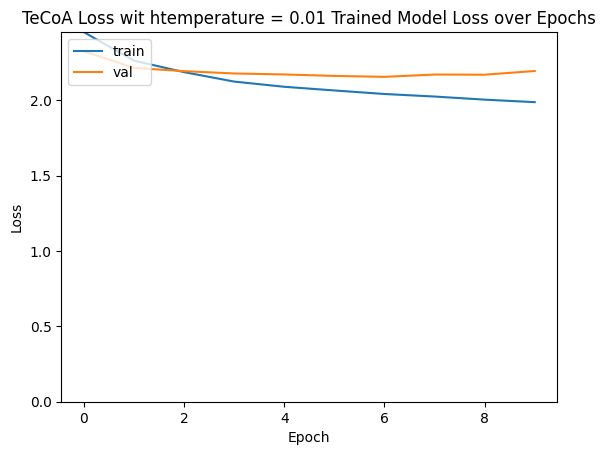

In [31]:
model2 = CLIPModel.from_pretrained(model_name).to(device)
model2 = get_peft_model(model2, lora_config)

optimizer = torch.optim.SGD(model2.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = tecoa_loss
hist2 = train(model2, trainloader, valloader, criterion, optimizer, epochs, device)
plot_history(hist2,'TeCoA Loss wit htemperature = 0.01 Trained')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


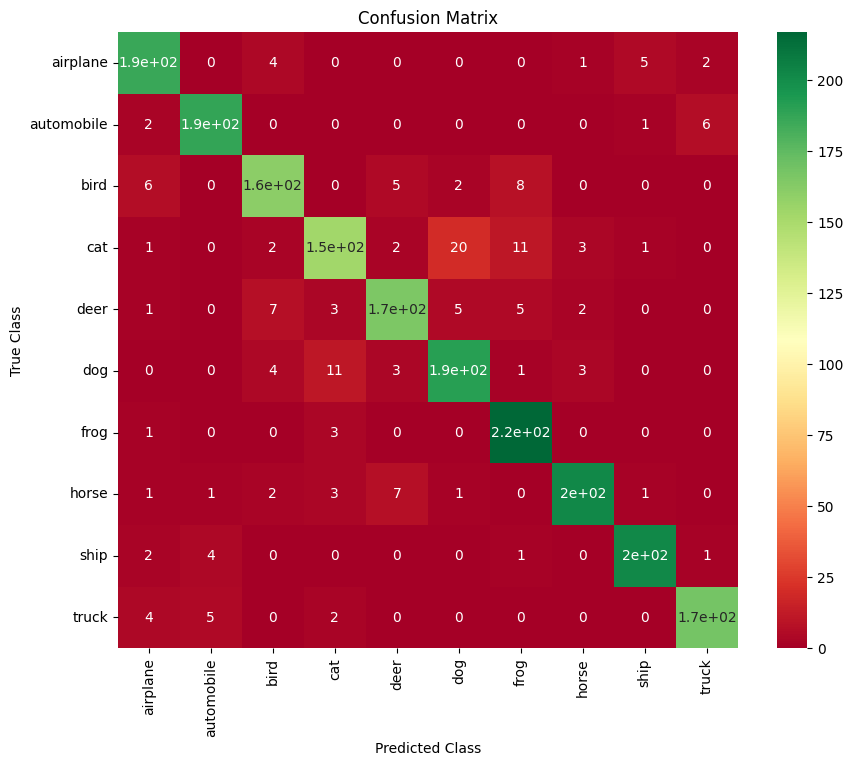

In [32]:
y_pred, y_true = get_predictions(model2,valloader,text_features,device)
scores = evaluate(y_pred,y_true,classes)


In [33]:
scores.round(4)


,Accuracy,Precision,Recall,F1 score
Micro,0.9170,0.9170,0.9170,0.9170
Macro,0.9170,0.9171,0.9155,0.9158
Wieghted,0.9170,0.9171,0.9170,0.9165
airplane,0.9850,0.9118,0.9394,0.9254
automobile,0.9905,0.9495,0.9543,0.9519
bird,0.9800,0.8944,0.8846,0.8895
cat,0.9690,0.8743,0.7927,0.8315
deer,0.9800,0.9071,0.8783,0.8925
dog,0.9750,0.8721,0.8967,0.8843
frog,0.9850,0.8930,0.9819,0.9353


## Increase Temperature

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [1] Average Training Loss: 3.4050


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [1] Average Validation Loss: 2.9364


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [2] Average Training Loss: 2.8247


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [2] Average Validation Loss: 2.6893


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [3] Average Training Loss: 2.6612


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [3] Average Validation Loss: 2.5930


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [4] Average Training Loss: 2.5777


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [4] Average Validation Loss: 2.5285


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [5] Average Training Loss: 2.5175


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [5] Average Validation Loss: 2.4840


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [6] Average Training Loss: 2.4641


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [6] Average Validation Loss: 2.4728


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [7] Average Training Loss: 2.4177


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [7] Average Validation Loss: 2.4246


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [8] Average Training Loss: 2.3884


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [8] Average Validation Loss: 2.4075


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [9] Average Training Loss: 2.3560


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [9] Average Validation Loss: 2.4165


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [10] Average Training Loss: 2.3367


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [10] Average Validation Loss: 2.3733


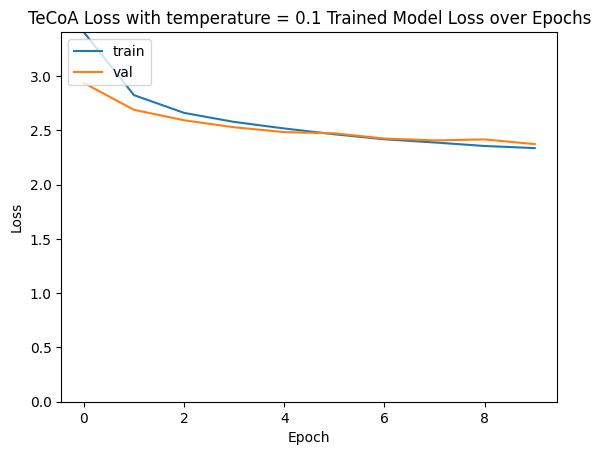

In [34]:
temperature = 0.1
model3 = CLIPModel.from_pretrained(model_name).to(device)
model3 = get_peft_model(model3, lora_config)

optimizer = torch.optim.SGD(model3.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = tecoa_loss
hist3 = train(model3, trainloader, valloader, criterion, optimizer, epochs, device)
plot_history(hist3,'TeCoA Loss with temperature = 0.1 Trained')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


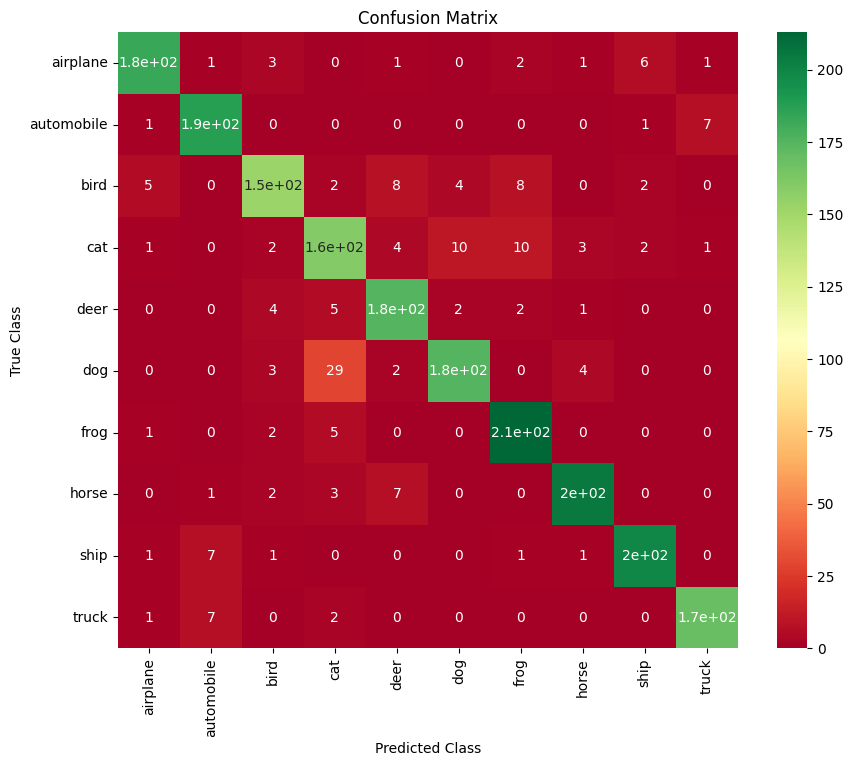

In [35]:
y_pred, y_true = get_predictions(model3,valloader,text_features,device)
scores = evaluate(y_pred,y_true,classes)


In [36]:
scores.round(4)


,Accuracy,Precision,Recall,F1 score
Micro,0.9100,0.9100,0.9100,0.9100
Macro,0.9100,0.9104,0.9092,0.9092
Wieghted,0.9100,0.9112,0.9100,0.9099
airplane,0.9875,0.9482,0.9242,0.9361
automobile,0.9875,0.9216,0.9543,0.9377
bird,0.9770,0.9000,0.8407,0.8693
cat,0.9605,0.7767,0.8290,0.8020
deer,0.9820,0.8883,0.9259,0.9067
dog,0.9730,0.9162,0.8216,0.8663
frog,0.9845,0.9025,0.9638,0.9322


## Visual Prompt Tuning

In [37]:
class VPT_CLIP(nn.Module):
    def __init__(self, image_size, model_name="openai/clip-vit-base-patch32"):
        super().__init__()

        self.image_size = image_size
        self.clip_model = CLIPModel.from_pretrained(model_name).to(device)
        self.clip_model.eval()
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.learned_bias = nn.Parameter(torch.zeros(3, image_size, image_size))

    def get_image_features(self, pixel_values):
        x = pixel_values + self.learned_bias.unsqueeze(0)
        return self.clip_model.get_image_features(pixel_values=x)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [1] Average Training Loss: 2.7340


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [1] Average Validation Loss: 2.6855


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [2] Average Training Loss: 2.7073


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [2] Average Validation Loss: 2.6493


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [3] Average Training Loss: 2.6846


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [3] Average Validation Loss: 2.6667


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [4] Average Training Loss: 2.6988


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [4] Average Validation Loss: 2.6507


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [5] Average Training Loss: 2.6825


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [5] Average Validation Loss: 2.6653


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [6] Average Training Loss: 2.6758


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [6] Average Validation Loss: 2.6359


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [7] Average Training Loss: 2.6976


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [7] Average Validation Loss: 2.6389


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [8] Average Training Loss: 2.6817


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [8] Average Validation Loss: 2.6545


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [9] Average Training Loss: 2.6779


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [9] Average Validation Loss: 2.6439


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [10] Average Training Loss: 2.6651


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [10] Average Validation Loss: 2.6311


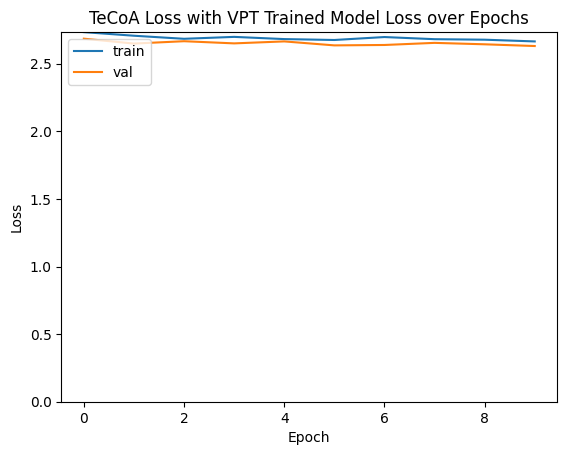

In [38]:
temperature = 0.01
model4 = VPT_CLIP(224).to(device)

optimizer = torch.optim.SGD(model4.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = tecoa_loss
hist4 = train(model4, trainloader, valloader, criterion, optimizer, epochs, device)
plot_history(hist4,'TeCoA Loss with VPT Trained')


(-0.5, 223.5, 223.5, -0.5)

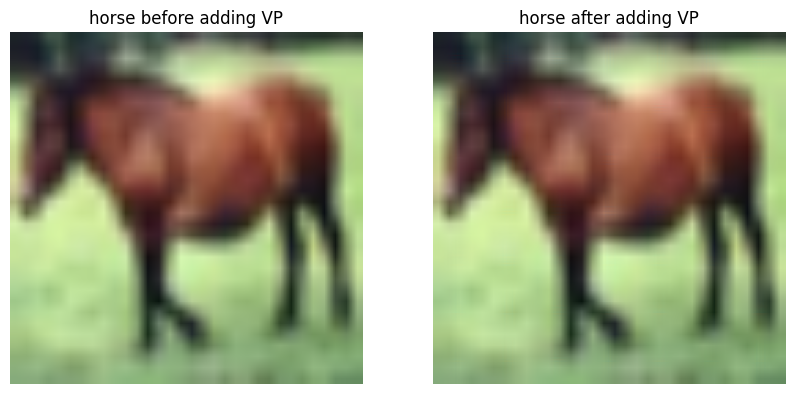

In [ ]:
plt.figure(figsize=(10, 8))
img, label = trainset[i]
unscaled_img = img * clip_std + clip_mean

plt.subplot(1, 2, 1)
plt.imshow(np.transpose(unscaled_img, (1, 2, 0)))
plt.title(f"{classes[label]} before adding VP")
plt.axis('off')

plt.subplot(1, 2, 2)
img = img.to(device)+model4.learned_bias
unscaled_img = img * clip_std + clip_mean
plt.imshow(np.transpose(unscaled_img.cpu().detach().numpy(), (1, 2, 0)))
plt.title(f"{classes[label]} after adding VP")
plt.axis('off')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


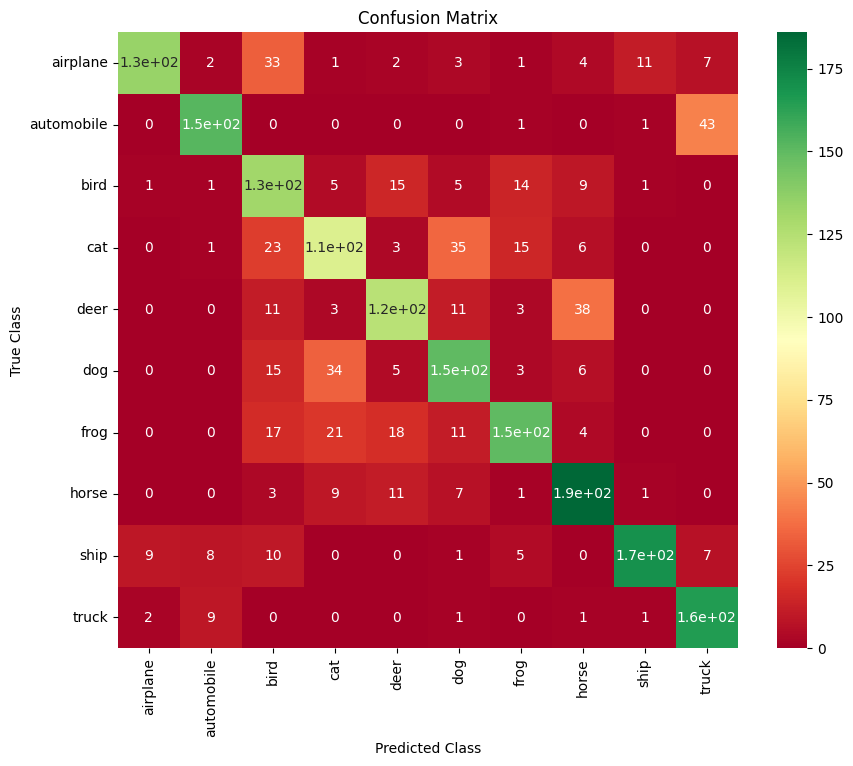

In [39]:
y_pred, y_true = get_predictions(model4,valloader,text_features,device)
scores = evaluate(y_pred,y_true,classes)


In [40]:
scores.round(4)


,Accuracy,Precision,Recall,F1 score
Micro,0.7355,0.7355,0.7355,0.7355
Macro,0.7355,0.7473,0.7356,0.7357
Wieghted,0.7355,0.7502,0.7355,0.7373
airplane,0.9620,0.9178,0.6768,0.7791
automobile,0.9670,0.8786,0.7716,0.8216
bird,0.9185,0.5391,0.7198,0.6165
cat,0.9220,0.6011,0.5699,0.5851
deer,0.9400,0.6949,0.6508,0.6721
dog,0.9315,0.6696,0.7042,0.6865
frog,0.9430,0.7772,0.6787,0.7246


# Evaluate on Test Dataset

In [41]:
test_model1 = CLIPModel.from_pretrained(model_name).to(device)


In [42]:
test_model2 = CLIPModel.from_pretrained(model_name).to(device)
test_model2 = get_peft_model(test_model2, lora_config)

optimizer = torch.optim.SGD(test_model2.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
train(test_model2, trainvalloader, testloader, criterion_wrapper, optimizer, epochs, device,report_val=False)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [1] Average Training Loss: 2.2568


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [2] Average Training Loss: 2.2446


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [3] Average Training Loss: 2.2241


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [4] Average Training Loss: 2.1838


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [5] Average Training Loss: 2.1514


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [6] Average Training Loss: 2.1317


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [7] Average Training Loss: 2.1168


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [8] Average Training Loss: 2.1030


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [9] Average Training Loss: 2.0919


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [10] Average Training Loss: 2.0840


{'train_loss': [2.2567941519864805,
  2.2445690449635696,
  2.2240924258141,
  2.1837787415571275,
  2.1514380631173493,
  2.131685551564405,
  2.116777345633051,
  2.102986085187098,
  2.0919409739743373,
  2.084039770114194],
 'val_loss': []}

In [43]:
test_model3 = CLIPModel.from_pretrained(model_name).to(device)
test_model3 = get_peft_model(test_model3, lora_config)

optimizer = torch.optim.SGD(test_model3.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = tecoa_loss
train(test_model3, trainvalloader, testloader, criterion, optimizer, epochs, device,report_val=False)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [1] Average Training Loss: 2.4129


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [2] Average Training Loss: 2.2274


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [3] Average Training Loss: 2.1620


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [4] Average Training Loss: 2.1152


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [5] Average Training Loss: 2.0824


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [6] Average Training Loss: 2.0490


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [7] Average Training Loss: 2.0387


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [8] Average Training Loss: 2.0062


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [9] Average Training Loss: 1.9823


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [10] Average Training Loss: 1.9930


{'train_loss': [2.412921379705903,
  2.2273539737531336,
  2.161969543262652,
  2.115236501784841,
  2.0824165367017127,
  2.0489660645746124,
  2.0386850097376827,
  2.0061642721200443,
  1.982311798129112,
  1.9930428501906667],
 'val_loss': []}

In [44]:
test_model4 = VPT_CLIP(224).to(device)

optimizer = torch.optim.SGD(test_model4.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
criterion = tecoa_loss
train(test_model4, trainvalloader, testloader, criterion, optimizer, epochs, device,report_val=False)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [1] Average Training Loss: 2.7093


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [2] Average Training Loss: 2.6999


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [3] Average Training Loss: 2.6840


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [4] Average Training Loss: 2.6752


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [5] Average Training Loss: 2.6724


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [6] Average Training Loss: 2.6702


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [7] Average Training Loss: 2.6610


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [8] Average Training Loss: 2.6680


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [9] Average Training Loss: 2.6605


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch [10] Average Training Loss: 2.6619


{'train_loss': [2.709263723367339,
  2.6999324932219877,
  2.6839606040602275,
  2.675191917996498,
  2.6723511234210555,
  2.6701939963990715,
  2.6609993945261476,
  2.668018679709951,
  2.66053285872101,
  2.6619343294459545],
 'val_loss': []}

In [45]:
models = [test_model1,test_model2,test_model3,test_model4]
preds = []
trues = []

testloader.set_clean_mode()
for model in models:
    y_pred, y_true = get_predictions(model,testloader,text_features,device)
    preds.append(y_pred)
    trues.append(y_true)

testloader.set_attack_mode()
for model in models:
    y_pred, y_true = get_predictions(model,testloader,text_features,device)
    preds.append(y_pred)
    trues.append(y_true)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [48]:
names = ['Clean CLIP','Clean LORA Crossentropy Loss', 'Clean LORA TeCoA Loss','Clean VPT TeCoA Loss', 'Adv CLIP','Adv LORA Crossentropy Loss', 'Adv LORA TeCoA Loss','Adv VPT TeCoA Loss']
scores = defaultdict(lambda: defaultdict(float))

for i,name in enumerate(names):
    true = trues[i]
    pred = preds[i]

    acc = accuracy_score(true,pred)
    precision = precision_score(true,pred,average='weighted')
    recall = recall_score(true,pred,average='weighted')
    f_score = f1_score(true,pred,average='weighted')

    scores[name]['Accuracy'] = acc
    scores[name]['Precision'] = precision
    scores[name]['Recall'] = recall
    scores[name]['F1 Score'] = f_score

pd.DataFrame(scores).T.round(4)


,Accuracy,Precision,Recall,F1 Score
Clean CLIP,0.8765,0.8810,0.8765,0.8765
Clean LORA Crossentropy Loss,0.9170,0.9187,0.9170,0.9164
Clean LORA TeCoA Loss,0.9485,0.9490,0.9485,0.9485
Clean VPT TeCoA Loss,0.8866,0.8907,0.8866,0.8869
Adv CLIP,0.7231,0.7346,0.7231,0.7226
Adv LORA Crossentropy Loss,0.8208,0.8261,0.8208,0.8189
Adv LORA TeCoA Loss,0.9047,0.9065,0.9047,0.9050
Adv VPT TeCoA Loss,0.7417,0.7534,0.7417,0.7428


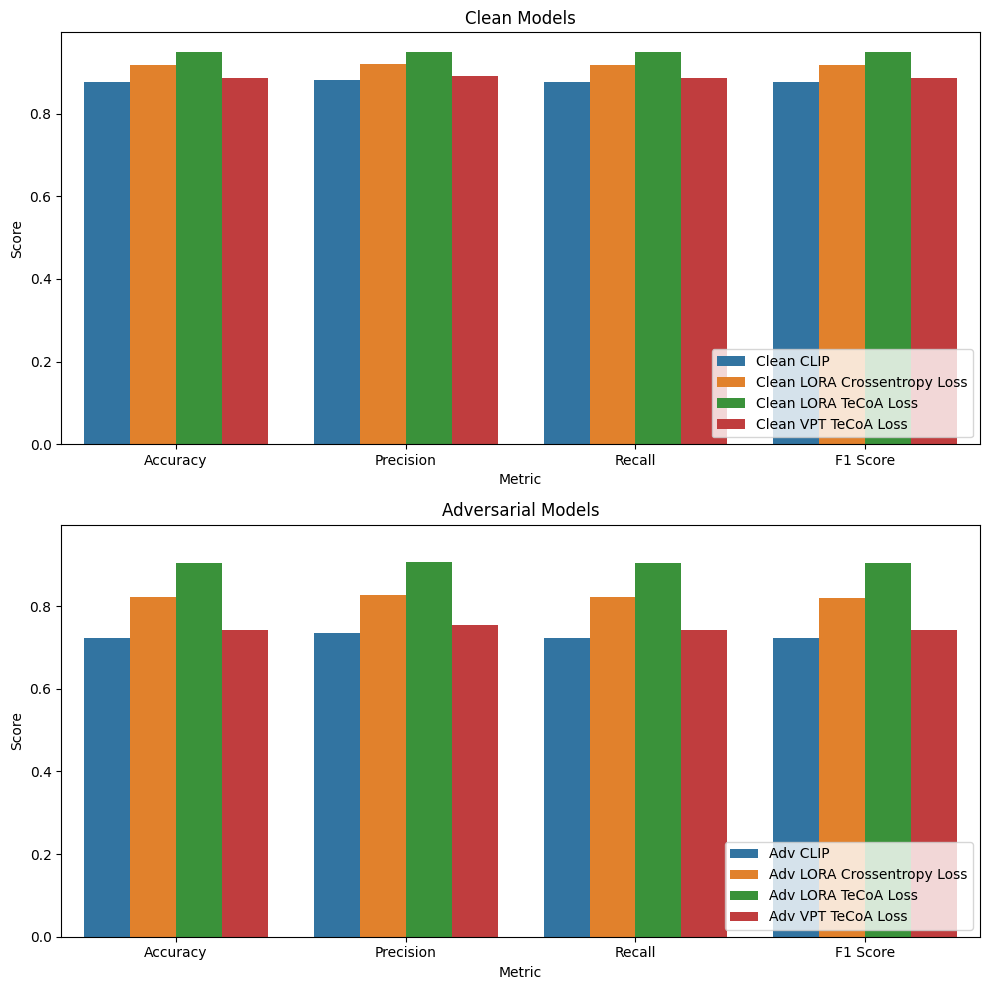

In [ ]:
df = pd.DataFrame(scores).T

df_long = df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
df_long.rename(columns={'index': 'Model'}, inplace=True)

df_clean = df_long[df_long['Model'].str.startswith("Clean")]
df_adv = df_long[df_long['Model'].str.startswith("Adv")]

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharey=True)

sns.barplot(data=df_clean, x='Metric', y='Score', hue='Model', ax=axes[0])
axes[0].set_title("Clean Models")

sns.barplot(data=df_adv, x='Metric', y='Score', hue='Model', ax=axes[1])
axes[1].set_title("Adversarial Models")

for ax in axes:
    ax.set_ylabel("Score")
    ax.legend(loc='lower right')

fig.tight_layout()
plt.show()


# Neural Networks and Deep Learning
## CA5 - Question 1

**Libraries**

In [ ]:
pip install transformers torchattacks


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import Subset, random_split, DataLoader, Dataset
from transformers import CLIPModel, CLIPProcessor
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from torchvision.transforms import functional as TF
import torch.nn.functional as F
from collections import defaultdict
from peft import LoraConfig, get_peft_model, PeftModel, TaskType
import torchattacks
import seaborn as sns
import pandas as pd
np.random.seed(42)


# Prepare the dataset

In [ ]:
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
clip_mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3,1,1)
clip_std=torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3,1,1)

cifar_mean=torch.tensor([0.49139968, 0.48215827 ,0.44653124]).view(3,1,1)
cifar_std=torch.tensor([0.24703233, 0.24348505, 0.26158768]).view(3,1,1)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224,224)),
                                 transforms.Normalize(clip_mean, clip_std)])


In [ ]:
num_train = 10000
train_size = int(0.8 * num_train)
val_size = num_train - train_size
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
indices = np.random.choice(len(trainset), num_train)
trainvalset = Subset(trainset,indices)
train_subset, val_subset = random_split(trainvalset, [train_size, val_size])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

len(train_subset),len(testset)


In [ ]:
n_sample = 5

plt.figure(figsize = (10,8))
for i in range(n_sample):
    img, label = trainset[i]
    img = img * clip_std + clip_mean
    plt.subplot(1,n_sample,i+1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(classes[label])
    plt.axis('off')


# Load the models

In [ ]:
target_model = torch.hub.load("chenyaofo/pytorch-cifar-models",
"cifar10_resnet20", pretrained=True)
target_model = target_model.to(device)
target_model.eval()
print()


In [ ]:
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
model.eval()
processor = CLIPProcessor.from_pretrained(model_name)


In [ ]:
class_texts = [f"a photo of a {c}" for c in classes]
inputs = processor(text=class_texts, return_tensors="pt", padding=True).to(device)
text_features = model.get_text_features(**inputs).to(device)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)
text_features = text_features.detach()


In [ ]:
class AdversarialDataLoader(DataLoader):
    def __init__(self, *args, attack, clean_args, adv_args, device, **kwargs):
        super().__init__(*args, **kwargs)
        self.attack = attack
        self.device = device
        self.attack_mode = False
        self.clean_mode = False

        self.clean_mean = clean_args['mean'].to(device)
        self.clean_std = clean_args['std'].to(device)
        self.clean_size = clean_args['size']

        self.adv_mean = adv_args['mean'].to(device)
        self.adv_std = adv_args['std'].to(device)
        self.adv_size = adv_args['size']

    def _apply_attack(self,images,labels):
        images = images * self.clean_std + self.clean_mean
        images = F.interpolate(images, size=self.adv_size, mode='bilinear', align_corners=False)
        images = (images - self.adv_mean) / self.adv_std

        images = self.attack(images, labels)

        images = images * self.adv_std + self.adv_mean
        images = F.interpolate(images, size=self.clean_size, mode='bilinear', align_corners=False)
        images = (images - self.clean_mean) / self.clean_std

        return images

    def __iter__(self):
        data_iter = super().__iter__()
        for images, labels in data_iter:
            images, labels = images.to(self.device), labels.to(self.device)

            if self.attack_mode and not self.clean_mode:
                images = self._apply_attack(images, labels)
                yield images, labels
            elif self.attack_mode:
                adv_images = self._apply_attack(images, labels)
                yield images, adv_images, labels
            else:
                yield images, labels

    def set_attack_mode(self):
        self.attack_mode = True
        self.clean_mode = False

    def set_clean_mode(self):
        self.attack_mode = False
        self.clean_mode = True

    def set_both_mode(self):
        self.attack_mode = True
        self.clean_mode = True


In [ ]:
attack = torchattacks.PGD(target_model, eps=8/255, alpha=2/255, steps=7, random_start = True)
attack.set_normalization_used(mean=cifar_mean, std=cifar_std)
clean_args = {'mean':clip_mean,'std':clip_std,'size':224}
adv_args = {'mean':cifar_mean,'std':cifar_std,'size':32}


In [ ]:
trainvalloader = AdversarialDataLoader(trainvalset, batch_size=batch_size, shuffle=True, num_workers=2,
                                       attack=attack,clean_args=clean_args,adv_args=adv_args,device=device)
trainloader = AdversarialDataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2,
                                   attack=attack,clean_args=clean_args,adv_args=adv_args,device=device)
valloader = AdversarialDataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2,
                                 attack=attack,clean_args=clean_args,adv_args=adv_args,device=device)
testloader = AdversarialDataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2,
                                  attack=attack,clean_args=clean_args,adv_args=adv_args,device=device)


# Evaluation

## Evaluate on clean images

In [ ]:
def get_predictions(model,data_loader,text_features,device):
    y_pred = []
    y_true = []
    model = model.eval().to(device)

    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            image_features = model.get_image_features(pixel_values=images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            logits = torch.matmul(image_features, text_features.T)
            probs = logits.softmax(dim=-1)
            y_pred.append(logits.argmax(dim=-1).cpu().numpy())

        y_true.append(labels.cpu().numpy())

    y_true = np.concatenate(y_true, axis=0).flatten()
    y_pred = np.concatenate(y_pred, axis=0).flatten()
    return y_pred, y_true


In [ ]:
df = pd.DataFrame(scores).T

df_long = df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
df_long.rename(columns={'index': 'Model'}, inplace=True)

df_clean = df_long[df_long['Model'].str.startswith("Clean")]
df_adv = df_long[df_long['Model'].str.startswith("Adv")]

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharey=True)

sns.barplot(data=df_clean, x='Metric', y='Score', hue='Model', ax=axes[0])
axes[0].set_title("Clean Models")

sns.barplot(data=df_adv, x='Metric', y='Score', hue='Model', ax=axes[1])
axes[1].set_title("Adversarial Models")

for ax in axes:
    ax.set_ylabel("Score")
    ax.legend(loc='lower right')

fig.tight_layout()
plt.show()